## Plot T and S for AW layer (27.3<$σ_θ$<27.4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import glob
import cartopy
import cartopy.crs as ccrs
import gsw

#### Load all theta and salt datasets

In [2]:
ecco_melville_theta_dir = Path('F:/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('F:/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [3]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [4]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [5]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

Need to make a coordinate that combines year, month, and day

In [6]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [7]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [8]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

Calculate density using T and S

In [9]:
# calculate potential density - reference 1000 kgm^(-3)
density_time_ds = gsw.density.sigma0(salt_time_ds.SALT, theta_time_ds.THETA)

#### Extract observations between 27.3 and 27.4 kgm^(-3)

In [10]:
salt_AW_ds = salt_time_ds.where(np.logical_and((density_time_ds>27.3),(density_time_ds<27.4)))
theta_AW_ds = theta_time_ds.where(np.logical_and((density_time_ds>27.3),(density_time_ds<27.4)))

#### Take weighted annual mean

In [ ]:
## calculate annual mean
salt_AW_annual_ds  = salt_AW_ds.mean(dim='time')
theta_AW_annual_ds = theta_AW_ds.mean(dim='time')

Assume grid cells have equal area = 3600 x 3600 m

In [ ]:
## load geometry file
ecco_geometry = xr.open_dataset("SASSIE_N1_geometry_v3.nc")

## extract upper 72 depth cells to match melville ecco dataset
ecco_vert_thickness = ecco_geometry.isel(k=slice(0,72)).drF.rename({"k":"depth"}) # grid cell vertical thickness (m)
## get total
ecco_vert_thickness_total = ecco_vert_thickness.sum()

In [ ]:
## take depth-weighted mean
salt_AW_annual_mean = (salt_AW_annual_ds*ecco_vert_thickness).sum(dim=['depth'])/ecco_vert_thickness_total
theta_AW_annual_mean = (theta_AW_annual_ds*ecco_vert_thickness).sum(dim=['depth'])/ecco_vert_thickness_total

In [ ]:
## load datasets to memory and save output

# can't do this - run out of memory
theta_AW_annual_mean.load().to_netcdf("slices_nc/theta_AW_iso_layer_annual.nc")

### Take unweighted annual mean

In [11]:
## calculate annual mean
salt_AW_annual_ds  = salt_AW_ds.mean(dim=['time','depth'])
theta_AW_annual_ds = theta_AW_ds.mean(dim=['time','depth'])

In [ ]:
# also can't do this - run out of memory
theta_AW_annual_ds.load().to_netcdf("slices_nc/theta_AW_iso_layer_annual.nc")

### Calculate daily max temp for 350 m

In [10]:
## subset 350 m layer
salt_350m_ds = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=350, method='nearest')
theta_350m_ds = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=350, method='nearest')

In [11]:
## extract max temp over time series for each grid cell
salt_350m_max_ds = salt_350m_ds.max(dim='time').assign_coords({"latitude":salt_350m_ds.isel(time=0).latitude,\
                                                               "longitude":salt_350m_ds.isel(time=0).longitude})
theta_350m_max_ds = theta_350m_ds.max(dim='time').assign_coords({"latitude":salt_350m_ds.isel(time=0).latitude,\
                                                                 "longitude":salt_350m_ds.isel(time=0).longitude})

##### Plot - model grid coordinates

In [12]:
slices_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
land_mask = xr.open_dataset(slices_dir + "land_mask_latlon.nc")

In [13]:
## subset lines that we extracted for AW boxes
salt_row000_AW_line = salt_350m_max_ds.SALT.isel(rows=0,  cols=slice(185,210))
salt_row025_AW_line = salt_350m_max_ds.SALT.isel(rows=25, cols=slice(160,180))
salt_row050_AW_line = salt_350m_max_ds.SALT.isel(rows=50, cols=slice(145,160))
salt_row075_AW_line = salt_350m_max_ds.SALT.isel(rows=75, cols=slice(145,170))
salt_row100_AW_line = salt_350m_max_ds.SALT.isel(rows=100,cols=slice(125,155))
salt_row125_AW_line = salt_350m_max_ds.SALT.isel(rows=125,cols=slice(125,145))
salt_row150_AW_line = salt_350m_max_ds.SALT.isel(rows=150,cols=slice(130,145))

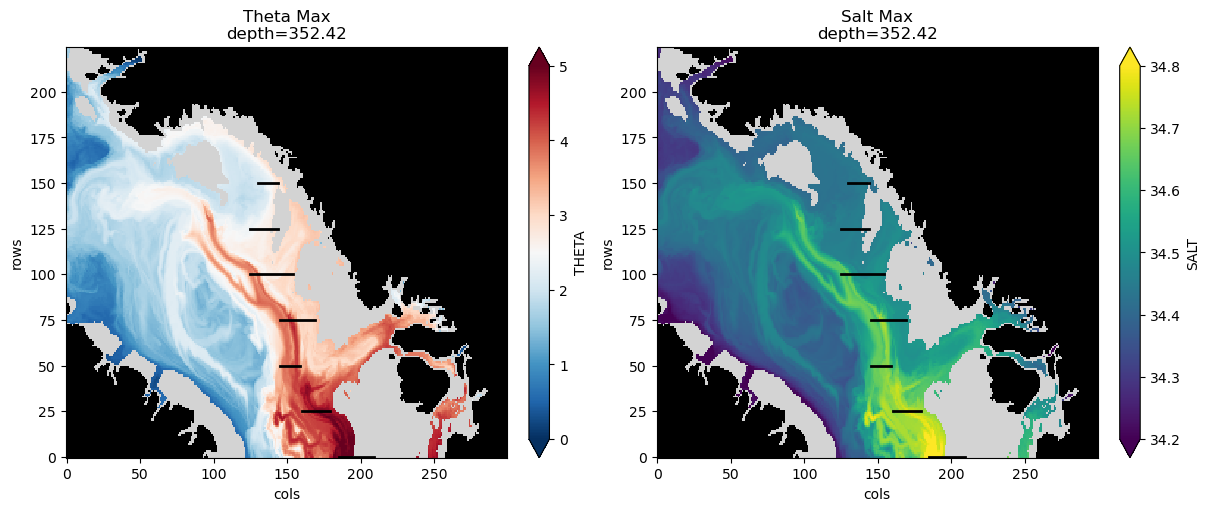

In [14]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

theta_350m_max_ds.THETA.where(salt_350m_max_ds.SALT>0).plot(ax=ax1,vmin=0,vmax=5,cmap='RdBu_r')
salt_350m_max_ds.SALT.where(salt_350m_max_ds.SALT>0).plot(ax=ax2,vmin=34.2,vmax=34.8)

for ax in (ax1,ax2):
    ax.set_facecolor('lightgray')
    
    # add lines
    ax.plot(np.arange(185,210), [0]*len(np.arange(185,210)),  color='k',linewidth=2)
    ax.plot(np.arange(160,180), [25]*len(np.arange(160,180)), color='k',linewidth=2)
    ax.plot(np.arange(145,160), [50]*len(np.arange(145,160)), color='k',linewidth=2)
    ax.plot(np.arange(145,170), [75]*len(np.arange(145,170)), color='k',linewidth=2)
    ax.plot(np.arange(125,155), [100]*len(np.arange(125,155)),color='k',linewidth=2)
    ax.plot(np.arange(125,145), [125]*len(np.arange(125,145)),color='k',linewidth=2)
    ax.plot(np.arange(130,145), [150]*len(np.arange(130,145)),color='k',linewidth=2)
    
    land_mask.SALT.plot(ax=ax,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1)

ax1.set_title("Theta Max\ndepth=" + str(theta_350m_max_ds.depth.values));
ax2.set_title("Salt Max\ndepth=" + str(theta_350m_max_ds.depth.values));

##### Plot - lat lon grid coordinates

In [17]:
gebco_bathy = xr.open_dataset("F:/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc")

In [18]:
gebco_bathy_select = gebco_bathy.sel(lon=slice(-75,-56),lat=slice(69,76)).elevation.load()

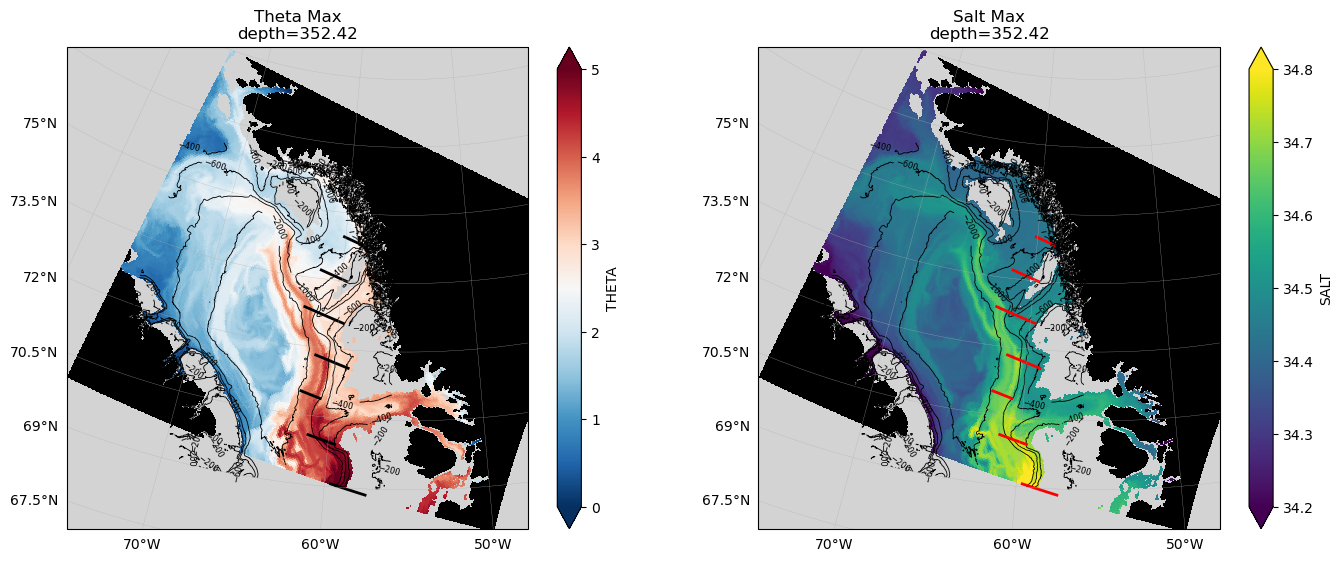

In [19]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_max_ds.THETA.where(salt_350m_max_ds.SALT>0).plot(y='latitude',x='longitude',ax=ax1,vmin=0,vmax=5,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_max_ds.SALT.where(salt_350m_max_ds.SALT>0).plot(y='latitude',x='longitude',ax=ax2,vmin=34.2,vmax=34.8,transform=ccrs.PlateCarree())
land_mask.SALT.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    CS = gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400,-200],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    ax.clabel(CS, CS.levels, inline=True, fontsize=6);
    
## add lines for what boxes we are selecting along each row
ax1.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

## add lines for what boxes we are selecting along each row
ax2.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='r',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta Max\ndepth=" + str(theta_350m_max_ds.depth.values));
ax2.set_title("Salt Max\ndepth=" + str(theta_350m_max_ds.depth.values));

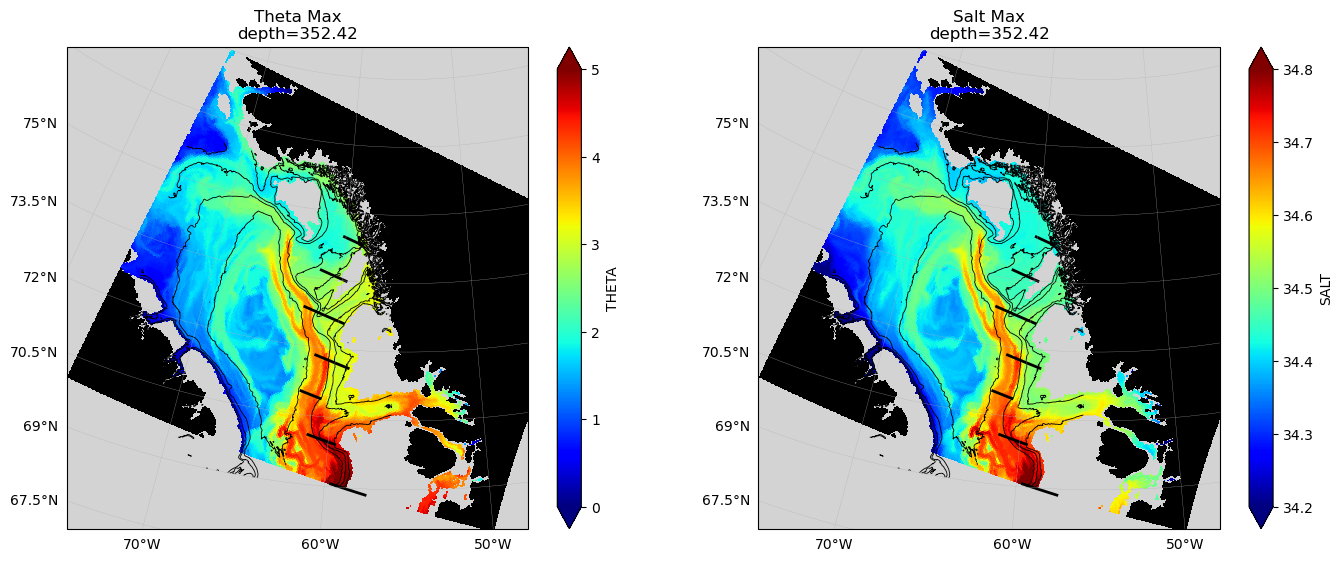

In [20]:
fig = plt.figure(figsize=(14,5.5), constrained_layout=True)
ax1 = fig.add_subplot(1,2,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())
ax2.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

## ax1
theta_350m_max_ds.THETA.where(salt_350m_max_ds.SALT>0).plot(y='latitude',x='longitude',ax=ax1,vmin=0,vmax=5,cmap='jet',transform=ccrs.PlateCarree())
land_mask.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## ax2
salt_350m_max_ds.SALT.where(salt_350m_max_ds.SALT>0).plot(y='latitude',x='longitude',ax=ax2,cmap='jet',vmin=34.2,vmax=34.8,transform=ccrs.PlateCarree())
land_mask.SALT.plot(y='latitude',x='longitude',ax=ax2,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

## plot rows over model area
for ax in (ax1,ax2):
    
    ax.set_facecolor('lightgray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                      xpadding=6,ypadding=6,rotate_labels=False)
    gl.top_labels = False
    gl.right_labels = False
    
    CS = gebco_bathy_select.plot.contour(ax=ax,levels=[-2000,-1000,-600,-400],\
                                         linestyles='solid',linewidths=0.6,colors='k',\
                                         transform=ccrs.PlateCarree())
    # ax.clabel(CS, CS.levels, inline=True, fontsize=6);
    
## add lines for what boxes we are selecting along each row
ax1.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax1.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

## add lines for what boxes we are selecting along each row
ax2.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())
ax2.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',linewidth=2,transform=ccrs.PlateCarree())

ax1.set_title("Theta Max\ndepth=" + str(theta_350m_max_ds.depth.values));
ax2.set_title("Salt Max\ndepth=" + str(theta_350m_max_ds.depth.values));